In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler 
from sklearn.compose import ColumnTransformer



from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import TomekLinks

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install --quiet optuna

     |████████████████████████████████| 296kB 8.4MB/s 
     |████████████████████████████████| 81kB 5.7MB/s 
     |████████████████████████████████| 163kB 12.3MB/s 
     |████████████████████████████████| 143kB 13.9MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 112kB 16.0MB/s 
     |████████████████████████████████| 81kB 7.2MB/s 


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import optuna

In [ ]:
#Reading the data
data = pd.read_csv('arrhythmia.data',header = None)

In [ ]:
# For this data set, the missing values are filled with ?. In this step '?' is replaced with np.Nan
data.replace('?',np.NaN,inplace=True)

In [ ]:
#Exploring the data
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,13,64,-2,NaN,63,0,52,44,0,0,32,0,0,0,0,0,0,0,44,20,36,0,28,0,0,0,0,0,0,52,...,0.0,8.4,-10.0,0.0,0.0,0.6,5.9,-3.9,52.7,-0.3,0.0,15.2,-8.4,0.0,0.0,0.9,5.1,17.7,70.7,-0.4,0.0,13.5,-4.0,0.0,0.0,0.9,3.9,25.5,62.9,-0.3,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,37,-17,31,NaN,53,0,48,0,0,0,24,0,0,0,0,0,0,0,64,0,0,0,24,0,0,0,0,0,0,32,...,0.0,5.8,-7.7,0.0,0.0,0.9,3.8,-5.7,27.7,-0.2,0.0,9.5,-5.0,0.0,0.0,0.5,2.6,11.8,34.6,-0.4,0.0,11.0,-2.4,0.0,0.0,0.4,2.6,21.6,43.4,-0.5,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,34,70,66,23,75,0,40,80,0,0,24,0,0,0,0,0,0,20,56,52,0,0,40,0,0,0,0,0,0,28,...,0.0,5.8,-4.1,4.0,-0.5,0.4,0.3,20.4,23.3,0.7,0.0,10.0,-5.7,0.0,0.0,0.5,2.2,-3.0,20.7,1.3,0.0,11.1,-3.4,0.0,0.0,0.4,3.4,11.5,48.2,0.9,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,11,-5,20,NaN,71,0,72,20,0,0,48,0,0,0,0,0,0,0,64,36,0,0,36,0,0,0,0,0,0,20,...,0.0,9.0,-7.9,0.0,0.0,0.1,4.1,7.6,51.0,0.4,0.0,15.0,-5.5,0.0,0.0,0.1,3.3,28.8,63.1,0.1,0.0,15.2,-3.7,0.0,0.0,0.6,3.0,36.8,68.0,0.1,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,13,61,3,NaN,NaN,0,48,40,0,0,28,0,0,0,0,0,0,0,40,24,0,0,24,0,0,0,0,0,0,52,...,0.0,8.5,-10.2,0.0,0.0,-1.0,4.7,-4.0,43.0,-0.2,0.0,15.2,-7.8,0.0,0.0,-0.1,4.9,16.2,63.2,-0.2,0.0,9.1,-0.9,0.0,0.0,-0.2,2.9,21.7,48.9,-0.4,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7


In [ ]:
 #Splitting the data into predictors and outcome.
 X = data[data.columns[0:279]]
 y = data[data.columns[-1]]

In [ ]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278
0,75,0,190,80,91,193,371,174,121,-16,13,64,-2,NaN,63,0,52,44,0,0,32,0,0,0,0,0,0,0,44,20,36,0,28,0,0,0,0,0,0,52,...,-0.1,0.0,8.4,-10.0,0.0,0.0,0.6,5.9,-3.9,52.7,-0.3,0.0,15.2,-8.4,0.0,0.0,0.9,5.1,17.7,70.7,-0.4,0.0,13.5,-4.0,0.0,0.0,0.9,3.9,25.5,62.9,-0.3,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4
1,56,1,165,64,81,174,401,149,39,25,37,-17,31,NaN,53,0,48,0,0,0,24,0,0,0,0,0,0,0,64,0,0,0,24,0,0,0,0,0,0,32,...,0.0,0.0,5.8,-7.7,0.0,0.0,0.9,3.8,-5.7,27.7,-0.2,0.0,9.5,-5.0,0.0,0.0,0.5,2.6,11.8,34.6,-0.4,0.0,11.0,-2.4,0.0,0.0,0.4,2.6,21.6,43.4,-0.5,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8
2,54,0,172,95,138,163,386,185,102,96,34,70,66,23,75,0,40,80,0,0,24,0,0,0,0,0,0,20,56,52,0,0,40,0,0,0,0,0,0,28,...,0.0,0.0,5.8,-4.1,4.0,-0.5,0.4,0.3,20.4,23.3,0.7,0.0,10.0,-5.7,0.0,0.0,0.5,2.2,-3.0,20.7,1.3,0.0,11.1,-3.4,0.0,0.0,0.4,3.4,11.5,48.2,0.9,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0
3,55,0,175,94,100,202,380,179,143,28,11,-5,20,NaN,71,0,72,20,0,0,48,0,0,0,0,0,0,0,64,36,0,0,36,0,0,0,0,0,0,20,...,0.7,0.0,9.0,-7.9,0.0,0.0,0.1,4.1,7.6,51.0,0.4,0.0,15.0,-5.5,0.0,0.0,0.1,3.3,28.8,63.1,0.1,0.0,15.2,-3.7,0.0,0.0,0.6,3.0,36.8,68.0,0.1,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6
4,75,0,190,80,88,181,360,177,103,-16,13,61,3,NaN,NaN,0,48,40,0,0,28,0,0,0,0,0,0,0,40,24,0,0,24,0,0,0,0,0,0,52,...,-0.5,0.0,8.5,-10.2,0.0,0.0,-1.0,4.7,-4.0,43.0,-0.2,0.0,15.2,-7.8,0.0,0.0,-0.1,4.9,16.2,63.2,-0.2,0.0,9.1,-0.9,0.0,0.0,-0.2,2.9,21.7,48.9,-0.4,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8


In [ ]:

print(y.value_counts())
print(len(y))

1     245
10     50
2      44
6      25
16     22
4      15
3      15
5      13
9       9
15      5
14      4
7       3
8       2
Name: 279, dtype: int64
452


<Figure size 1280x640 with 0 Axes>

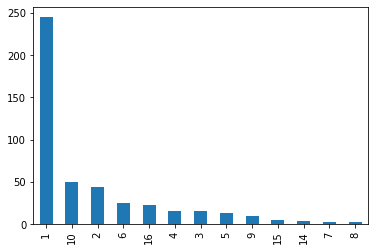

<Figure size 1280x640 with 0 Axes>

In [ ]:
#Plotting the distribution of target variables.
data[279].value_counts().plot(kind = 'bar')
figure(figsize=(16, 8), dpi=80)

####From the graph we can observe that the data is not properly balaced. One can consider the techniques like oversampling the minority label or undersampling the majority label. Since the data is imbalanced, we have to perform stratified.

### Approach 1: Convert the problem into a binary classification. 
##### Inspect the proportion of label '1' and othr labels combined. Translate the problem such that model classifes 1 and 0.

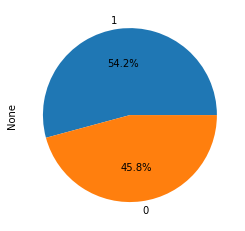

In [ ]:
y_binary = pd.Series([ 1 if i == 1 else 0 for i in y])
y_binary.value_counts().plot(kind = 'pie',autopct='%1.1f%%')

From the above chart we can observe the labels are not completley balanced, but distribution is not skewed. 

## Inspect the independent variables

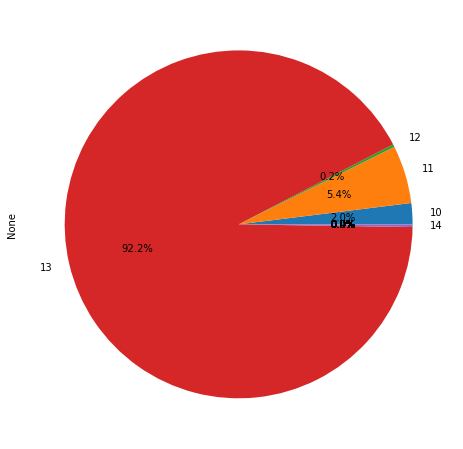

In [ ]:
#Checking for missing values.
X.isna().sum().plot(kind = 'pie',figsize=(16, 8),autopct='%1.1f%%')

Columns 10,11,12,13, and 14 have missing values. One should inspect the type of the variabl replace with either mean or mode accordingly.


The columns 10,11,12,13,and 14 are:
 Vector angles in degrees on front plane of:, linear <br>
     10 QRS <br>
     11 T <br>
     12 P <br>
     13 QRST <br>
     14 J <br>

     Since they are linear, they can be replaced by mean.

For Machine learning algorithms, plan is to use Optuna to find the best classifier and its corresponding  hyper-parameter. For machine learning we are splitting into train and test, but not train ,test and val. Since optuna uses the training data to perform cross validation to perform hyper-parameter tuning.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.20, random_state=42)

In [ ]:
col_missing_values = [10,11,12,13,14]

for i in col_missing_values:
    X_train[i] = X_train[i].astype(float)
    X_test[i] = X_test[i].astype(float)

train_mean={}
for i in col_missing_values :
    train_mean[i] = X_train[i].mean() 

for i in col_missing_values:
  X_train[i].replace(np.nan,train_mean[i],inplace= True)
  X_test[i].replace(np.nan,train_mean[i],inplace= True)

nominal_cols = []
nominal_cols.append(1)
wave_cols = [15,27,39,51,63,75,87,99,111,123,135,147]
for x in wave_cols:
  sub_col = [i for i in range(x+6,x+12)]
  nominal_cols.extend(sub_col)

for i in nominal_cols:
  X_train[i] = X_train[i].astype(str).astype(int)
  X_test[i] = X_test[i].astype(str).astype(int)


clf = StandardScaler()
clf.fit(X_train)
X_train = pd.DataFrame(clf.transform(X_train))
X_test = pd.DataFrame(clf.transform(X_test))

Using Optuna to identify the best hyper-parameters.

In [ ]:
def objective(trial):
    
    
    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForestClassifier","LogReg", "ElasticNet"])
    
    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        model = sklearn.svm.SVC(C=svc_c, gamma="auto")
        
    elif classifier_name == "RandomForestClassifier":
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32)
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 2, 128, log=True)
        model = sklearn.ensemble.RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=rf_n_estimators
        )

    elif classifier_name == 'LogReg':
        logreg_c = trial.suggest_float("logreg_c", 1e-10, 1e10, log=True)
        model = sklearn.linear_model.LogisticRegression(C=logreg_c)

    elif classifier_name == "ElasticNet":
        en_l1_ratio = trial.suggest_float("en_l1_ratio", 0, 1, log=False)
        model = sklearn.linear_model.ElasticNet(l1_ratio=en_l1_ratio)
        
    score = sklearn.model_selection.cross_val_score(model, X_train, y_train, cv=3)
    accuracy = score.mean()
    
    return accuracy

In [ ]:
cstudy = optuna.create_study(direction="maximize")
cstudy.optimize(objective, n_trials=30)

[I 2021-04-27 22:00:33,661] A new study created in memory with name: no-name-ff10fe40-01b7-41d9-9cd1-17e0f3c3e5ec
[I 2021-04-27 22:00:33,818] Trial 0 finished with value: 0.6842975206611571 and parameters: {'classifier': 'SVC', 'svc_c': 36119.39355950725}. Best is trial 0 with value: 0.6842975206611571.
[I 2021-04-27 22:00:33,955] Trial 1 finished with value: 0.5567952249770431 and parameters: {'classifier': 'SVC', 'svc_c': 1.2411551527793794e-07}. Best is trial 0 with value: 0.6842975206611571.
[I 2021-04-27 22:00:34,006] Trial 2 finished with value: -0.01487367437021662 and parameters: {'classifier': 'ElasticNet', 'en_l1_ratio': 0.42805158475974225}. Best is trial 0 with value: 0.6842975206611571.
[I 2021-04-27 22:00:34,207] Trial 3 finished with value: 0.6842975206611571 and parameters: {'classifier': 'SVC', 'svc_c': 1960635.6830331748}. Best is trial 0 with value: 0.6842975206611571.
[I 2021-04-27 22:00:34,387] Trial 4 finished with value: 0.6869605142332414 and parameters: {'class

In [ ]:
cstudy.best_trial


FrozenTrial(number=24, values=[0.7949954086317722], datetime_start=datetime.datetime(2021, 4, 27, 22, 0, 42, 241584), datetime_complete=datetime.datetime(2021, 4, 27, 22, 0, 42, 659571), params={'classifier': 'RandomForestClassifier', 'rf_max_depth': 6, 'rf_n_estimators': 67}, distributions={'classifier': CategoricalDistribution(choices=('SVC', 'RandomForestClassifier', 'LogReg', 'ElasticNet')), 'rf_max_depth': IntUniformDistribution(high=32, low=2, step=1), 'rf_n_estimators': IntLogUniformDistribution(high=128, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=24, state=TrialState.COMPLETE, value=None)

In [ ]:
cstudy.best_params

{'classifier': 'RandomForestClassifier',
 'rf_max_depth': 6,
 'rf_n_estimators': 67}

In [ ]:
model = sklearn.ensemble.RandomForestClassifier(
            max_depth= 6, n_estimators= 67
        )
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=67,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
prediction_test= model.predict(X_test)
print(f1_score(y_test, prediction_test) * 100)

78.84615384615384


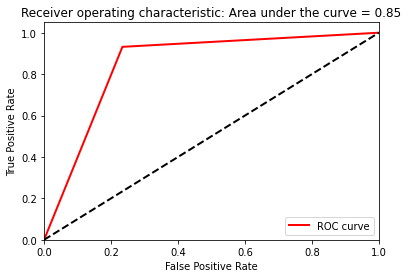

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,prediction_test,pos_label=1)
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

## MLP Optuna

In [ ]:
from sklearn.neural_network import MLPClassifier
from keras.regularizers import l2

In [ ]:
def objective_mlp(trial):
    

    kwargs = {}
    kwargs['activation'] = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    kwargs['solver'] = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
    kwargs['alpha'] = trial.suggest_float("alpha", 1e-5, 1e-5, log=True)
    
    n_layers = trial.suggest_int("n_layers", 1, 3)
    hidden_layer_sizes = []
    for n in range(n_layers):
        hidden_layer_sizes.append(
            trial.suggest_int("n_units_l%d" % n, 4, 128, log=True)
        )
    
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, **kwargs)
    
    score = sklearn.model_selection.cross_val_score(model, X_train, y_train, cv=3)
    accuracy = score.mean()
    
    return accuracy

In [ ]:
mlpstudy = optuna.create_study(direction="maximize")
mlpstudy.optimize(objective_mlp, n_trials=5)

[I 2021-04-26 10:48:27,212] A new study created in memory with name: no-name-b546c278-3a04-4ce4-b250-18811290da37
[I 2021-04-26 10:48:27,297] Trial 0 finished with value: 0.6666666666666666 and parameters: {'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 1e-05, 'n_layers': 1, 'n_units_l0': 5}. Best is trial 0 with value: 0.6666666666666666.
[I 2021-04-26 10:48:28,453] Trial 1 finished with value: 0.6925925925925925 and parameters: {'activation': 'relu', 'solver': 'adam', 'alpha': 1e-05, 'n_layers': 3, 'n_units_l0': 43, 'n_units_l1': 15, 'n_units_l2': 105}. Best is trial 1 with value: 0.6925925925925925.
[I 2021-04-26 10:48:28,825] Trial 2 finished with value: 0.6851851851851851 and parameters: {'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 1e-05, 'n_layers': 1, 'n_units_l0': 41}. Best is trial 1 with value: 0.6925925925925925.
[I 2021-04-26 10:48:28,951] Trial 3 finished with value: 0.6962962962962962 and parameters: {'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 1e-05, 'n_la

In [ ]:
mlpstudy.best_trial

FrozenTrial(number=3, values=[0.6962962962962962], datetime_start=datetime.datetime(2021, 4, 26, 10, 48, 28, 830615), datetime_complete=datetime.datetime(2021, 4, 26, 10, 48, 28, 950674), params={'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 1e-05, 'n_layers': 1, 'n_units_l0': 16}, distributions={'activation': CategoricalDistribution(choices=('identity', 'logistic', 'tanh', 'relu')), 'solver': CategoricalDistribution(choices=('lbfgs', 'sgd', 'adam')), 'alpha': LogUniformDistribution(high=1e-05, low=1e-05), 'n_layers': IntUniformDistribution(high=3, low=1, step=1), 'n_units_l0': IntLogUniformDistribution(high=128, low=4, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=3, state=TrialState.COMPLETE, value=None)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[279]),
    keras.layers.Dense(18, activation="relu"),
    #keras.layers.Dense(5, activation="relu"),
    #keras.layers.Dense(15, activation="relu", kernel_regularizer=l2(1e-05)),
    #keras.layers.Dense(4, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate = 0.001 , momentum=0.00),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val))

Epoch 1/20
9/9 [==============================] - 1s 42ms/step - loss: 0.7801 - accuracy: 0.5534 - val_loss: 0.7455 - val_accuracy: 0.5934
Epoch 2/20
9/9 [==============================] - 0s 7ms/step - loss: 0.7144 - accuracy: 0.5777 - val_loss: 0.7414 - val_accuracy: 0.6044
Epoch 3/20
9/9 [==============================] - 0s 8ms/step - loss: 0.7271 - accuracy: 0.5694 - val_loss: 0.7375 - val_accuracy: 0.6044
Epoch 4/20
9/9 [==============================] - 0s 7ms/step - loss: 0.6775 - accuracy: 0.6145 - val_loss: 0.7343 - val_accuracy: 0.5934
Epoch 5/20
9/9 [==============================] - 0s 7ms/step - loss: 0.7038 - accuracy: 0.5936 - val_loss: 0.7307 - val_accuracy: 0.6154
Epoch 6/20
9/9 [==============================] - 0s 7ms/step - loss: 0.6829 - accuracy: 0.6048 - val_loss: 0.7275 - val_accuracy: 0.6154
Epoch 7/20
9/9 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.6103 - val_loss: 0.7245 - val_accuracy: 0.6044
Epoch 8/20
9/9 [=================

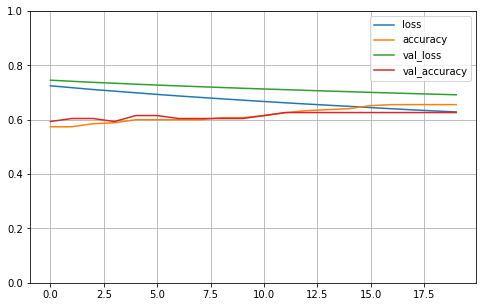

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

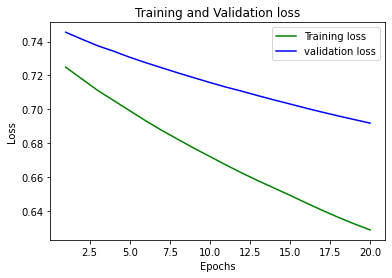

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

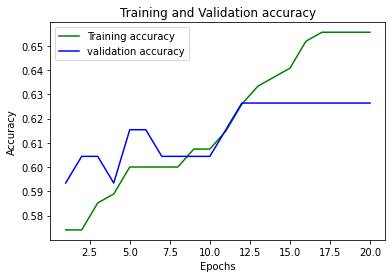

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Multi Layer Perceptron

In [ ]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y_binary, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.25, random_state=42)

In [ ]:
col_missing_values = [10,11,12,13,14]

for i in col_missing_values:
    X_train[i] = X_train[i].astype(float)
    X_val[i] = X_val[i].astype(float)
    X_test[i] = X_test[i].astype(float)

train_mean={}
for i in col_missing_values :
    train_mean[i] = X_train[i].mean() 

for i in col_missing_values:
  X_train[i].replace(np.nan,train_mean[i],inplace= True)
  X_val[i].replace(np.nan,train_mean[i],inplace= True)
  X_test[i].replace(np.nan,train_mean[i],inplace= True)

nominal_cols = []
nominal_cols.append(1)
wave_cols = [15,27,39,51,63,75,87,99,111,123,135,147]
for x in wave_cols:
  sub_col = [i for i in range(x+6,x+12)]
  nominal_cols.extend(sub_col)

for i in nominal_cols:
  X_train[i] = X_train[i].astype(str).astype(int)
  X_val[i] = X_val[i].astype(str).astype(int)
  X_test[i] = X_test[i].astype(str).astype(int)


clf = StandardScaler()
clf.fit(X_train)
X_train = pd.DataFrame(clf.transform(X_train))
X_val = pd.DataFrame(clf.transform(X_val))
X_test = pd.DataFrame(clf.transform(X_test))

In [ ]:
def plot(history,epoch):
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  epochs = range(1,epoch+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


  loss_train = history.history['accuracy']
  loss_val = history.history['val_accuracy']
  epochs = range(1,epoch+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
keras.backend.clear_session()
np.random.seed(425)
tf.random.set_seed(425)

In [ ]:
model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[279]),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(4, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model1.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.RMSprop(learning_rate = 0.001 , momentum=0.00),
              metrics=["accuracy"])

history1 = model1.fit(X_train, y_train, epochs = 50,
                    validation_data=(X_val, y_val))

Epoch 1/50
9/9 [==============================] - 1s 42ms/step - loss: 0.8999 - accuracy: 0.4926 - val_loss: 0.7519 - val_accuracy: 0.5934
Epoch 2/50
9/9 [==============================] - 0s 7ms/step - loss: 0.7127 - accuracy: 0.5422 - val_loss: 0.7158 - val_accuracy: 0.5934
Epoch 3/50
9/9 [==============================] - 0s 8ms/step - loss: 0.6354 - accuracy: 0.6110 - val_loss: 0.6865 - val_accuracy: 0.6264
Epoch 4/50
9/9 [==============================] - 0s 8ms/step - loss: 0.6266 - accuracy: 0.5830 - val_loss: 0.6729 - val_accuracy: 0.6264
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 0.6091 - accuracy: 0.6201 - val_loss: 0.6669 - val_accuracy: 0.6374
Epoch 6/50
9/9 [==============================] - 0s 9ms/step - loss: 0.5734 - accuracy: 0.6540 - val_loss: 0.6647 - val_accuracy: 0.6374
Epoch 7/50
9/9 [==============================] - 0s 8ms/step - loss: 0.5420 - accuracy: 0.7213 - val_loss: 0.6638 - val_accuracy: 0.6374
Epoch 8/50
9/9 [=================

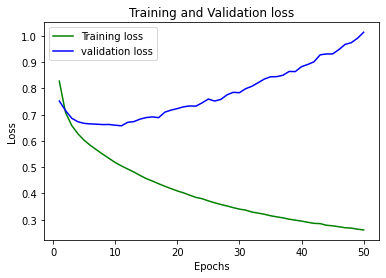

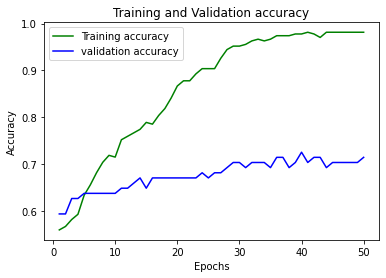

In [ ]:
plot(history1,50)

In [ ]:
predictions1 = model1.predict_classes(X_test)
acc_score = accuracy_score(y_test, predictions1)
print(acc_score*100)

56.043956043956044


In [ ]:
keras.backend.clear_session()
np.random.seed(425)
tf.random.set_seed(425)

In [ ]:
model2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[279]),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation="sigmoid")
])

model2.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.RMSprop(learning_rate = 0.001 , momentum=0.00),
              metrics=["accuracy"])

history2 = model2.fit(X_train, y_train, epochs=50,
                    validation_data=(X_val, y_val))

Epoch 1/50
9/9 [==============================] - 1s 37ms/step - loss: 1.0541 - accuracy: 0.5641 - val_loss: 0.9133 - val_accuracy: 0.5824
Epoch 2/50
9/9 [==============================] - 0s 8ms/step - loss: 0.8433 - accuracy: 0.5770 - val_loss: 0.8607 - val_accuracy: 0.5824
Epoch 3/50
9/9 [==============================] - 0s 8ms/step - loss: 0.7717 - accuracy: 0.5947 - val_loss: 0.8331 - val_accuracy: 0.6154
Epoch 4/50
9/9 [==============================] - 0s 7ms/step - loss: 0.7079 - accuracy: 0.6922 - val_loss: 0.7965 - val_accuracy: 0.6484
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 0.6714 - accuracy: 0.6571 - val_loss: 0.7847 - val_accuracy: 0.6703
Epoch 6/50
9/9 [==============================] - 0s 7ms/step - loss: 0.8005 - accuracy: 0.6295 - val_loss: 0.7576 - val_accuracy: 0.6703
Epoch 7/50
9/9 [==============================] - 0s 7ms/step - loss: 0.7124 - accuracy: 0.6820 - val_loss: 0.7335 - val_accuracy: 0.6923
Epoch 8/50
9/9 [=================

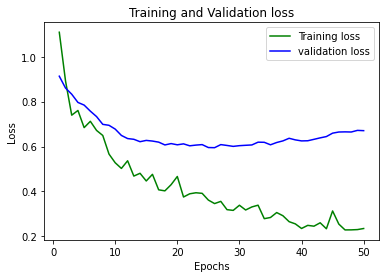

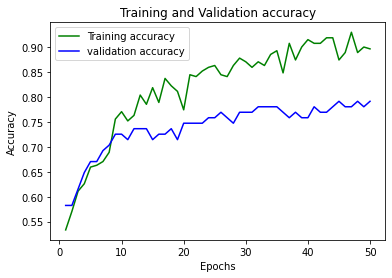

In [ ]:
plot(history2,50)

In [ ]:
predictions2 = model2.predict_classes(X_test)
acc_score = f1_score(y_test, predictions2)
print(acc_score*100)

76.47058823529412


### CNN

In [ ]:
keras.backend.clear_session()
np.random.seed(425)
tf.random.set_seed(425)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D,Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
from numpy import unique
from keras.layers.advanced_activations import LeakyReLU

In [ ]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y_binary, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.25, random_state=42)

In [ ]:
col_missing_values = [10,11,12,13,14]

for i in col_missing_values:
    X_train[i] = X_train[i].astype(float)
    X_val[i] = X_val[i].astype(float)
    X_test[i] = X_test[i].astype(float)

train_mean={}
for i in col_missing_values :
    train_mean[i] = X_train[i].mean() 

for i in col_missing_values:
  X_train[i].replace(np.nan,train_mean[i],inplace= True)
  X_val[i].replace(np.nan,train_mean[i],inplace= True)
  X_test[i].replace(np.nan,train_mean[i],inplace= True)

nominal_cols = []
nominal_cols.append(1)
wave_cols = [15,27,39,51,63,75,87,99,111,123,135,147]
for x in wave_cols:
  sub_col = [i for i in range(x+6,x+12)]
  nominal_cols.extend(sub_col)

for i in nominal_cols:
  X_train[i] = X_train[i].astype(str).astype(int)
  X_val[i] = X_val[i].astype(str).astype(int)
  X_test[i] = X_test[i].astype(str).astype(int)


clf = StandardScaler()
clf.fit(X_train)
X_train = pd.DataFrame(clf.transform(X_train))
X_val = pd.DataFrame(clf.transform(X_val))
X_test = pd.DataFrame(clf.transform(X_test))

In [ ]:
X_train_numpy = X_train.to_numpy()
X_val_numpy  = X_val.to_numpy()
X_test_numpy  = X_test.to_numpy()

In [ ]:
X_train = X_train_numpy.reshape(X_train_numpy.shape[0], X_train.shape[1], 1)
X_test = X_test_numpy.reshape(X_test_numpy.shape[0], X_test.shape[1], 1)
X_val = X_val_numpy.reshape(X_val_numpy.shape[0], X_val.shape[1], 1)

In [ ]:
model3 = Sequential()
model3.add(Conv1D(256, 3, activation='relu',input_shape=(279,1),padding='same'))
model3.add(MaxPooling1D())
model3.add(Dropout(0.5))
model3.add(Conv1D(128, 3, activation='relu',input_shape=(279,1),padding='same'))
model3.add(MaxPooling1D())
model3.add(Dropout(0.25))
model3.add(Conv1D(64, 3, activation='relu',input_shape=(279,1),padding='same'))
model3.add(MaxPooling1D())
model3.add(Dropout(0.5))
model3.add(Flatten()) 
model3.add(Dense(64, activation='relu')) 
model3.add(Dropout(0.5))               
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss = keras.losses.binary_crossentropy, 
     optimizer = "adam",               
              metrics = ['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 279, 256)          1024      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 139, 256)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 139, 256)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 139, 128)          98432     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 69, 128)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 69, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 69, 64)           

In [ ]:
history = model3.fit(X_train, y_train, epochs=15,
                    validation_data=(X_val, y_val))

Epoch 1/15
9/9 [==============================] - 2s 153ms/step - loss: 0.6744 - accuracy: 0.5819 - val_loss: 0.6535 - val_accuracy: 0.6484
Epoch 2/15
9/9 [==============================] - 1s 125ms/step - loss: 0.6394 - accuracy: 0.6732 - val_loss: 0.6294 - val_accuracy: 0.6154
Epoch 3/15
9/9 [==============================] - 1s 123ms/step - loss: 0.6440 - accuracy: 0.6271 - val_loss: 0.5986 - val_accuracy: 0.7253
Epoch 4/15
9/9 [==============================] - 1s 123ms/step - loss: 0.6019 - accuracy: 0.7247 - val_loss: 0.5800 - val_accuracy: 0.7253
Epoch 5/15
9/9 [==============================] - 1s 125ms/step - loss: 0.5507 - accuracy: 0.7500 - val_loss: 0.5734 - val_accuracy: 0.6813
Epoch 6/15
9/9 [==============================] - 1s 124ms/step - loss: 0.5318 - accuracy: 0.7366 - val_loss: 0.5364 - val_accuracy: 0.7363
Epoch 7/15
9/9 [==============================] - 1s 123ms/step - loss: 0.5209 - accuracy: 0.7113 - val_loss: 0.5201 - val_accuracy: 0.7363
Epoch 8/15
9/9 [====

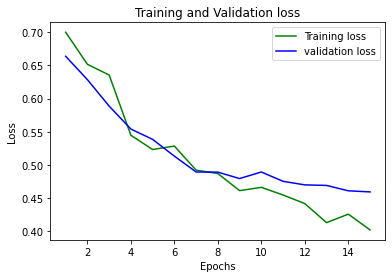

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

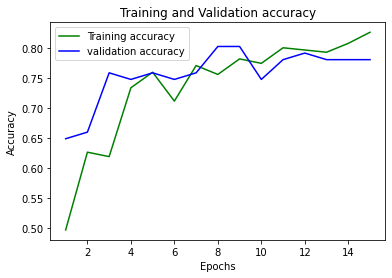

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
predictions3 = model3.predict_classes(X_test)
acc_score = f1_score(y_test, predictions3)
print(acc_score*100)

70.96774193548386
